In [1]:
# %%
import warnings
# pysumma has many depreciated packages, this ignores their warnings
warnings.filterwarnings("ignore", category=UserWarning, module='scipy')

from datetime import datetime, timedelta
from metloom.pointdata import SnotelPointData
import pandas as pd
import geopandas as gpd
import xarray as xr
from metsim import MetSim
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from metpy.units import units
import metpy.calc as mpcalc
import math
import scipy
import os
import shutil
from pytz import UTC
import pysumma as ps
import pysumma.plotting as psp  

In [2]:
def justify(a, invalid_val=np.nan, axis=1, side='right'):
    """
    Justifies a 2D array
    Courtesy: https://stackoverflow.com/questions/44558215/python-justifying-numpy-array/44559180#44559180

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """
    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val)
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

# Create forcing from Olallie Meadows for WY14 to WY24

In [35]:

snotel = '672:WA:SNTL'
out_name = 'olallie_WY14_WY24'
# out_path = input('Enter the output path (ie. ../model/forcings/): ')
out_path = '/home/cdalden/summa_setup/model/forcings/'

import sys
sys.path.append('/home/cdalden/summa_setup/model')
from utils import lw_clr
from utils import forcing_filler as ff
from utils import summa_check as sc

# %%
#  Create needed directories to store metsim run and snotel CSVs
if not os.path.exists('./input/'):
    os.makedirs('./input/')

if not os.path.exists('./out/'):
    os.makedirs('./out/')

if not os.path.exists('./snotel_csvs/'):
    os.makedirs('./snotel_csvs/')

if not os.path.exists('./forcings/'):
    os.makedirs('./forcings/')

# metsim and metloom require different formats of time and ranges, reformat here
water_year = 2024
water_year_str = str(water_year)
start_year = 2013
start_year_str = str(start_year)

start_date = datetime(start_year, 7, 3)
end_date = datetime(water_year, 9, 30)

spinstart = pd.to_datetime(start_year_str + '-07-03').tz_localize('UTC')
spinend = pd.to_datetime(start_year_str + '-09-30').tz_localize('UTC')

start_loc = datetime(start_year, 10, 1).replace(tzinfo=UTC)
mask_date = datetime(start_year, 10, 2).replace(tzinfo=UTC)

dates = pd.date_range('10/01/' + start_year_str, '09/30/' + water_year_str)

spin_range = pd.date_range('07/03/' + start_year_str, '09/30/' + start_year_str)

# Pull desired variables from snotel to dataframe
snotel_point = SnotelPointData(snotel, "MyStation")
df = snotel_point.get_hourly_data(
    start_date, end_date,
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM, snotel_point.ALLOWED_VARIABLES.TEMP]
)

print('Done with API call')

# Specify latitude, longitude, and elevation from station metadata
lat = snotel_point.metadata.y
lon = snotel_point.metadata.x
elev = snotel_point.metadata.z

# Clean up the dataframe
df.reset_index(inplace=True)

# Rename columns
replace = {'ACCUMULATED PRECIPITATION':'accppt','AIR TEMP':'airtemp', 'datetime':'time'}
df.rename(columns=replace, inplace=True)
df.set_index('time', inplace=True)

df.to_csv('./snotel_csvs/'+out_name+'.csv')

# add 'SNOWDEPTH' and 'SNOWDEPTH_units' to the droplist if it decides to work again
try:
    df.drop(columns=['site', 'ACCUMULATED PRECIPITATION_units', 'geometry', 'AIR TEMP_units', 'datasource', 
                 'SWE', 'SWE_units', 'SNOWDEPTH', 'SNOWDEPTH_units'], inplace=True)
except:
    df.drop(columns=['site', 'ACCUMULATED PRECIPITATION_units', 'geometry', 'AIR TEMP_units', 'datasource'], inplace=True)
    print('SNOTEL csv has no snowdepth for this run')

# %% [markdown]
# ## Fill missing timesteps from snotel data

# %%
# Convert the index of the dataframe to a DatetimeIndex
df.index = pd.to_datetime(df.index)

# Create a date range from the first to the last timestep
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Find the missing dates
missing_dates = date_range[~date_range.isin(df.index)]

# Print the missing dates
# print(missing_dates)

# Reindex the data DataFrame with the missing dates
# Concatenate the original DataFrame with a DataFrame containing the missing dates
new_df = pd.concat([df, pd.DataFrame(index=missing_dates)], axis=0)

# Sort the new DataFrame by the index
new_df = new_df.sort_index()
df = new_df

# Fill NaNs for every other column
df = df.fillna(np.nan)

# Rename index
df.index.name = 'time'

# %% [markdown]
# ## Unit Conversions

# %%
# Covert air temperature to celsius
df['airtemp'] = (df['airtemp'] - 32) * 5.0/9.0

# Convert precipitation to mm
df['accppt'] = df['accppt'] * 25.4

# Convert from geodataframe to dataframe
df = pd.DataFrame(df)


# %% [markdown]
# ## Split up data into spinup state and desired date range for MetSim

# %%
# Interpolate the missing values
df.interpolate(inplace=True)

# Seperate the data into two dataframes, before and after October 1
# spinstart = pd.to_datetime('2014-07-03').tz_localize('UTC')
# spinend = pd.to_datetime('2014-09-30').tz_localize('UTC')
spinup = df.loc[spinstart:spinend].copy()
data = df.loc[start_loc:]

# Copy the dataframe a2 to a2_copy
data_copy = data.copy()

# Create a mask to identify rows where the index is less than or equal to October 2, 2023
mask = data_copy.index <= mask_date

# Set the 'precip_accum' column to 0 for rows that satisfy the mask condition
data_copy.loc[mask, 'accppt'] = 0

# Update the value of a2 to the modified copy
data = data_copy

# Calculate the difference between the maximum value of 'precip_accum' and the previous value
spinup['pptrate'] = spinup['accppt'].cummax().diff()
data['pptrate'] = data['accppt'].cummax().diff()

# Drop accppt column
spinup.drop(columns=['accppt'], inplace=True)
data.drop(columns=['accppt'], inplace=True)

# %% [markdown]
# ## Generate SW from MetSim

# %%
# Create empty dataset
shape = (len(dates), 1, 1, )
dims = ('time', 'lat', 'lon', )

# We are running only one site, at these coordinates
lats = [lat]
lons = [lon]
elev = elev # meters
coords = {'time': dates, 'lat': lats, 'lon': lons}

# Create the initial met data input data structure
met_data = xr.Dataset(coords=coords)

# %%
for varname in ['prec', 't_min', 't_max']:
    met_data[varname] = xr.DataArray(data=np.full(shape, np.nan),
                                     coords=coords, dims=dims,
                                     name=varname)

# %%
# Resample the data to daily frequency and calculate the maximum and minimum temperatures
tmax_vals = data['airtemp'].resample('D').max()
tmin_vals = data['airtemp'].resample('D').min()

# Calculate the daily precipitation values
prec_vals = data['pptrate'].resample('D').sum()

# Interpolate the temperature values to fill in any missing days
# tmax_vals = tmax_vals.interpolate(method='linear')
# tmin_vals = tmin_vals.interpolate(method='linear')

met_data['prec'].values[:, 0, 0] = prec_vals

# Assign the daily maximum and minimum temperatures to the met_data xarray, converting to Celsius
met_data['t_min'].values[:, 0, 0] = tmin_vals
met_data['t_max'].values[:, 0, 0] = tmax_vals

met_data.to_netcdf('./input/rc_forcing.nc')

# %%
# We form the domain in a similar fashion
# First, by creating the data structure
coords = {'lat': lats, 'lon': lons}
domain = xr.Dataset(coords=coords)
domain['elev'] = xr.DataArray(data=np.full((1,1,), np.nan),
                          coords=coords,
                          dims=('lat', 'lon', ))
domain['mask'] = xr.DataArray(data=np.full((1,1,), np.nan),
                          coords=coords,
                          dims=('lat', 'lon', ))

# Add the data
domain['elev'][0, 0] = elev
domain['mask'][0, 0] = 1
domain.to_netcdf('./input/rc_domain.nc')

# %%
# Finally, we create the state file - the dates are 90 days prior to 
# the MetSim run dates - as usual, create an empty data structure to
# read the data into
shape = (len(spin_range), 1, 1, )
dims = ('time', 'lat', 'lon', )
coords = {'time': spin_range, 'lat': lats, 'lon': lons}
state = xr.Dataset(coords=coords)
for varname in ['prec', 't_min', 't_max']:
    state[varname] = xr.DataArray(data=np.full(shape, np.nan),
                               coords=coords, dims=dims,
                               name=varname)
    
# Resample precip to daily
prec_vals = spinup['pptrate'].resample('D').sum()

# Resample the data to daily frequency and calculate the maximum and minimum temperatures
tmax_vals = spinup['airtemp'].resample('D').max()
tmin_vals = spinup['airtemp'].resample('D').min()

# Do precip data
state['prec'].values[:, 0, 0] = prec_vals

# And now temp data and convert to C
state['t_min'].values[:, 0, 0] = tmin_vals
state['t_max'].values[:, 0, 0] = tmax_vals
state.to_netcdf('./input/rc_state.nc')

# %%
# dates = pd.date_range('10/01/2014', '09/30/2015')
params = {
    'time_step'    : "60",       
    'start'        : dates[0],
    'stop'         : dates[-1],
    'forcing'      : './input/rc_forcing.nc',     
    'domain'       : './input/rc_domain.nc',
    'state'        : './input/rc_state.nc',
    'forcing_fmt'  : 'netcdf',
    'out_dir'      : './out',
    'out_prefix': out_name,
    'scheduler'    : 'threading',
    'chunks'       : 
        {'lat': 1, 'lon': 1},
    'forcing_vars' : 
        {'prec' : 'prec', 't_max': 't_max', 't_min': 't_min'},
    'state_vars'   : 
        {'prec' : 'prec', 't_max': 't_max', 't_min': 't_min'},
    'domain_vars'  : 
        {'elev': 'elev', 'lat': 'lat', 'lon': 'lon', 'mask': 'mask'}
    }               

# Run MetSim
ms = MetSim(params)
ms.run()
output = ms.open_output().load()

print('Done with MetSim')

# Delete MetSim input and output directories to declutter, they are unnecessary
if os.path.exists('./input/'):
    shutil.rmtree('./input/')

if os.path.exists('./out/'):
    shutil.rmtree('./out/')

# %% [markdown]
# ## Create SUMMA forcing netCDF

# %%
out_df = output.to_dataframe()
out_df.reset_index(inplace=True)
out_df.set_index('time', inplace=True)

# %%
# Remove timezone from index
data.index = data.index.tz_convert(None)

# Convert precipitation rate from m hr^-1 to kg m^-2 s^-1
data['pptrate'] = data['pptrate']/3600

# Generate relative humidity assuming T_d is overnight low temperature
# Used to calculate specific humidity and longwave radiation
ff.fill_rel_hum(data)

# Convert airtemp to Kelvin
data['airtemp'] = (1.03*(data['airtemp']-0.9)) + 273.15 # Currier snotel temp correction

# Generate pressure from hypsometric equation and site elevation (1981m)
ff.fill_pressure(data, elev)

# Generate specific humidity
ff.fill_spec_hum(data)
data['spechum'] = data['spechum'].clip(lower=0.001)


# Set shortwave radiation to MetSim output
data['SWRadAtm'] = out_df['shortwave']

# Generate longwave radiation
data['LWRadAtm'] = lw_clr.dilleyobrien1998(data['airtemp'], data['rh'])

# Can alternatively use the MetSim LW radiation
# data['LWRadAtm'] = out_df['longwave']

# Set wind to 2 m/s
data['windspd'] = 2

# Fill in missing values
data['pptrate'] = data['pptrate'].fillna(0)

# Drop unnecessary columns
data = data.drop(columns=['rh'])

# Interpolate the missing values
data.interpolate(inplace=True)

# %%
# Load template forcing file to preserve attributes
template = xr.open_dataset('/home/cdalden/summa_setup/model/summa_forcing_template.nc')

# Convert dataframe to xarray
dsx = data.to_xarray()

# Loop through variables and add attributes from template forcing file
for data_var in dsx:
    dsx[data_var].attrs = template[data_var].attrs
    
# Add hru dimension
dsx = dsx.expand_dims(dim={'hru':1})

# Add gap-filled and datastep variables
dsx['gap_filled'] = xr.DataArray(np.ones((1,dsx.time.shape[0])),dims = ['hru','time'])
dsx['data_step'] = 3600 # 3600 seconds for 1hr timesteps

# Convert all to float64
for var in dsx.data_vars:
    dsx[var] = dsx[var].astype(np.float64)

# Set hruID based on template
dsx['hruId'] = (xr.DataArray(np.ones((1))*template['hruId'].values,dims = ['hru'])).astype(np.int32)

# Transpose all variables to match SUMMA dimensions
count = 0
for var in dsx.data_vars:
    # print(var,count)
    count += 1
    if count <= 7:
        attribs = dsx[var].attrs
        arr_t = dsx[var].values.T
        dsx[var] = xr.DataArray(dims = ['time','hru'],data = arr_t)
        dsx[var].attrs = attribs

# Set hruID based on template
dsx['hruId'] = (xr.DataArray(np.ones((1))*template['hruId'].values,dims = ['hru'])).astype(np.float64).fillna(0).astype(np.int32)

# Set time to match SUMMA format and save
dsx.to_netcdf(out_path+out_name+'.nc',
                        encoding = {"time":
                                        {'dtype' : 'float64',
                                         'units' : 'hours since 1990-01-01 00:00:00',
                                         'calendar' : 'standard'}})

Done with API call
SNOTEL csv has no snowdepth for this run
Done with MetSim


PermissionError: [Errno 13] Permission denied: b'/home/cdalden/summa_setup/model/forcings/olallie_WY14_WY24.nc'

# Run SUMMA for WY14 to WY24

In [8]:
# pysumma has many depreciated packages, this ignores their warnings
warnings.filterwarnings("ignore", category=UserWarning)

# %%
executable = 'summa.exe'
filemanager = '/home/cdalden/summa_setup/model/settings/file_manager_summa.txt'

# Create a pySUMMA simulation object
s = ps.Simulation(executable, filemanager)


# Set the simulation start and end times from forcing file
with open('/home/cdalden/summa_setup/model/forcings/forcing_file_list.txt', 'r') as file:
    # Read the contents
    forcing_file = file.read().replace("'", "")
forcing = xr.open_dataset('/home/cdalden/summa_setup/model/forcings/'+forcing_file.strip(), engine='netcdf4')
time = forcing['time']

dt64 = np.datetime64(time.isel(time=0).values)
dt = pd.to_datetime(dt64)
start = dt.strftime('%Y-%m-%d %H:%M')
dt64 = np.datetime64(time.isel(time=-1).values)
dt = pd.to_datetime(dt64)
end = dt.strftime('%Y-%m-%d %H:%M')

s.manager['simStartTime'] = start
s.manager['simEndTime'] = end

# Add in some additional variables so we can demonstrate plotting capabilities
output_settings = {'period': 1, 'instant': 1, 'sum': 0, 
              'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
layer_vars = ['mLayerTemp', 'mLayerDepth', 'mLayerHeight',
              'mLayerLiqFluxSoil', 'mLayerVolFracIce', 'mLayerVolFracLiq', 
              'mLayerVolFracWat','mLayerMatricHead', 'iLayerHeight', 'scalarSnowDepth', 'nSnow']

# Create the new variables
for var in layer_vars:
    s.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s.output_control.options])
for var in all_vars:
    s.output_control[var] = output_settings

# Set params
s.decisions['snowLayers'] = 'jrdn1991'
s.decisions['thCondSnow'] = 'tyen1965'
s.decisions['snowDenNew'] = 'hedAndPom'
s.decisions['compaction'] = 'consettl'
s.decisions['astability'] = 'mahrtexp'

s.global_hru_params['tempCritRain'] = 273.15
s.global_hru_params['newSnowDenMin'] = 50
s.global_hru_params['densScalGrowth'] = 0.10
s.global_hru_params['densScalOvrbdn'] = 0.025
s.global_hru_params['fixedThermalCond_snow'] = 0.35
s.global_hru_params['Fcapil'] = 0.04 # intially 0.06 for salmon
# s.global_hru_params['albedoDecayRate'] = 1.0d+5

out_name = os.path.splitext(forcing_file)[0]
s.run('local', run_suffix=out_name)

print('Model status:', s.status)

# Create and save density and temp profile plots
summa = s.output

Model status: Success


# Check results against WSDOT Obs

In [52]:
summa = xr.open_dataset('/home/cdalden/summa_setup/model/output/olallie/combined_olallie_WY14_WY24.nc')
summa = summa.sel(time=slice('2015-12-01', '2024-03-31'))

# drop times with nan values
summa = summa.dropna(dim='time')

In [53]:
depth = summa.isel(hru=0)['mLayerHeight']
idepth = summa.isel(hru=0)['iLayerHeight']
var = summa.isel(hru=0)['mLayerVolFracWat']
temp = summa.isel(hru=0)['mLayerTemp']
vmask = var != -9999
dmask = depth != -9999
idmask = idepth != -9999
tmask = temp != -9999
depth.values = justify(depth.where(dmask).values)
idepth.values = justify(idepth.where(idmask).values)
var.values = justify(var.where(vmask).values)
temp.values = justify(temp.where(tmask).values)


# Filter var where the average is less than 273.05
# Calculate the average at all layers
average_temp = temp.mean(dim='midToto')

# Filter var where the average is less than 273.15
filtered_var = var.where(average_temp < 273.15)

# Calculate the vertical derivative
derivative = filtered_var.diff(dim='midToto')

# Initialize the list to store counts
counts = []

# Loop over the 'time' dimension within the specified range
for t in var.time.values:
    # Select the derivative for the current timestep
    derivative_t = derivative.sel(time=t)

    # Calculate the running average over 3 layers
    running_avg = derivative_t.rolling(midToto=3, center=False).sum()

    # Filter values that are greater than or equal to 0.2 or less than or equal to -0.2
    threshold = 0.15
    filtered = running_avg.where((running_avg >= threshold) | (running_avg <= -threshold))

    # Count the number of layers with at least one such value
    count = np.isfinite(filtered).sum().values

    # Append the count to the list
    counts.append(count)

# Convert the list to a numpy array
counts = np.array(counts)

crust_days = counts.sum() / 24
mean_crusts = counts.mean()

# binary crust metric
crusts_binary = np.where(counts > 0, 1, 0).sum()

# Calculate '-summa['iLayerHeight'].isel(ifcToto=nSnow)'
nSnow = summa['nSnow'].values[0] # assuming 'nSnow' is a variable in 'summa'
hs = -summa['iLayerHeight'].isel(ifcToto=nSnow)

# Apply the condition 'layer_height > 0' and sum the result
snow_on = (hs > 0).sum()

# Apply the conditions and count the number of timesteps where both conditions are true
isothermal_days = ((hs > 0) & (average_temp > 273.15)).sum().item()

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [55]:
df = pd.DataFrame({
    'crusts_binary': counts
}, index=var.time.values)

# Resample to daily data
df_daily = df.resample('D').max()
df_daily['crusts_binary'] = df_daily['crusts_binary'].clip(upper=1)

# read in WSDOT obs
wsdot = pd.read_excel('/home/cdalden/summa_setup/analysis/Strat_Code-2013-2024.xlsx')

# Fill NaN values in the 'Strat' column with an empty string
wsdot['Strat'] = wsdot['Strat'].fillna('')

# Add a new column 'crust_binary' to the DataFrame
wsdot['crust_binary'] = wsdot['Strat'].str.contains('K|P').astype(int)
# wsdot['crust_binary'] = wsdot['Strat'].str.contains('K').astype(int)

# Convert the 'Date' column to datetime
wsdot['Date'] = pd.to_datetime(wsdot['Date'])

# Set the 'Date' column as the index
wsdot.set_index('Date', inplace=True)

# Group by 'Date' and take the maximum 'crust_binary' for each date
wsdot_binary = wsdot.groupby('Date')['crust_binary'].max()

# Add 'obs_crusts_binary' to 'df_daily'
df_daily['obs_crusts_binary'] = wsdot_binary

# Fill NaN values with 0
df_daily['obs_crusts_binary'].fillna(0, inplace=True)

# Convert 'obs_crusts_binary' to integer
df_daily['obs_crusts_binary'] = df_daily['obs_crusts_binary'].astype(int)

# Filter 'df_daily' to only include dates from December 1 to March 31 for each year
df_daily_short = df_daily[(df_daily.index.month >= 12) | (df_daily.index.month <= 3)]

# Further filter to ensure the correct day range within the months
# df_daily_short = df_daily_short[(df_daily_short.index.month != 12) | (df_daily_short.index.day >= 1)]
# df_daily_short = df_daily_short[(df_daily_short.index.month != 3) | (df_daily_short.index.day <= 31)]

/tmp/ipykernel_25831/893862635.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_daily['obs_crusts_binary'].fillna(0, inplace=True)


In [56]:
#Get the confusion matrix
cf_matrix = confusion_matrix(df_daily_short['crusts_binary'], df_daily_short['obs_crusts_binary'])
print(cf_matrix)

f1 = f1_score(df_daily_short['crusts_binary'], df_daily_short['obs_crusts_binary'])
print(f1)

ValueError: Input y_true contains NaN.

[Text(0, 0.5, 'SUMMA Miss'), Text(0, 1.5, 'SUMMA Hit')]

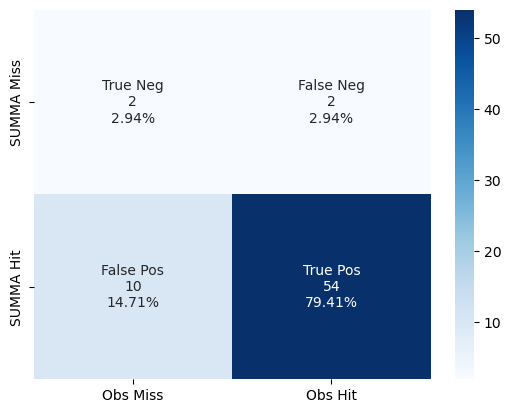

In [ ]:
import seaborn as sns
group_names = ['True Neg','False Neg','False Pos','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Label the ticks
ax.set_xticklabels(['Obs Miss', 'Obs Hit'])
ax.set_yticklabels(['SUMMA Miss', 'SUMMA Hit'])

# Create binary plots

In [ ]:
# transpose daily binary data
df_daily_short_T = df_daily_short.T
df_daily_T = df_daily.T

# Create a mask for dates not between December 1 and March 31
mask = (df_daily.index.month < 12) & (df_daily.index.month > 3)

df_daily_masked = df_daily

# Set all values to 0 if not between December 1 and March 31
df_daily_masked.loc[mask] = 0

df_daily_masked_T = df_daily_masked.T

In [ ]:
import matplotlib.colors as colors
import matplotlib.dates as mdates


# Create a colormap where 0 is white and 1 is blue
cmap = colors.ListedColormap(['white', 'blue'])

# Convert the index to a DatetimeIndex
df_daily_short.index = pd.to_datetime(df_daily_short.index)

# Convert the DatetimeIndex to a list of Python datetime objects
df_daily_short.index = df_daily_short.index.to_pydatetime()

# # Create the plot
# fig, ax = plt.subplots()
# cax = ax.imshow(df_daily_short, aspect='auto', cmap=cmap, interpolation='none')

# # Format the x-axis as dates
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# plt.show()

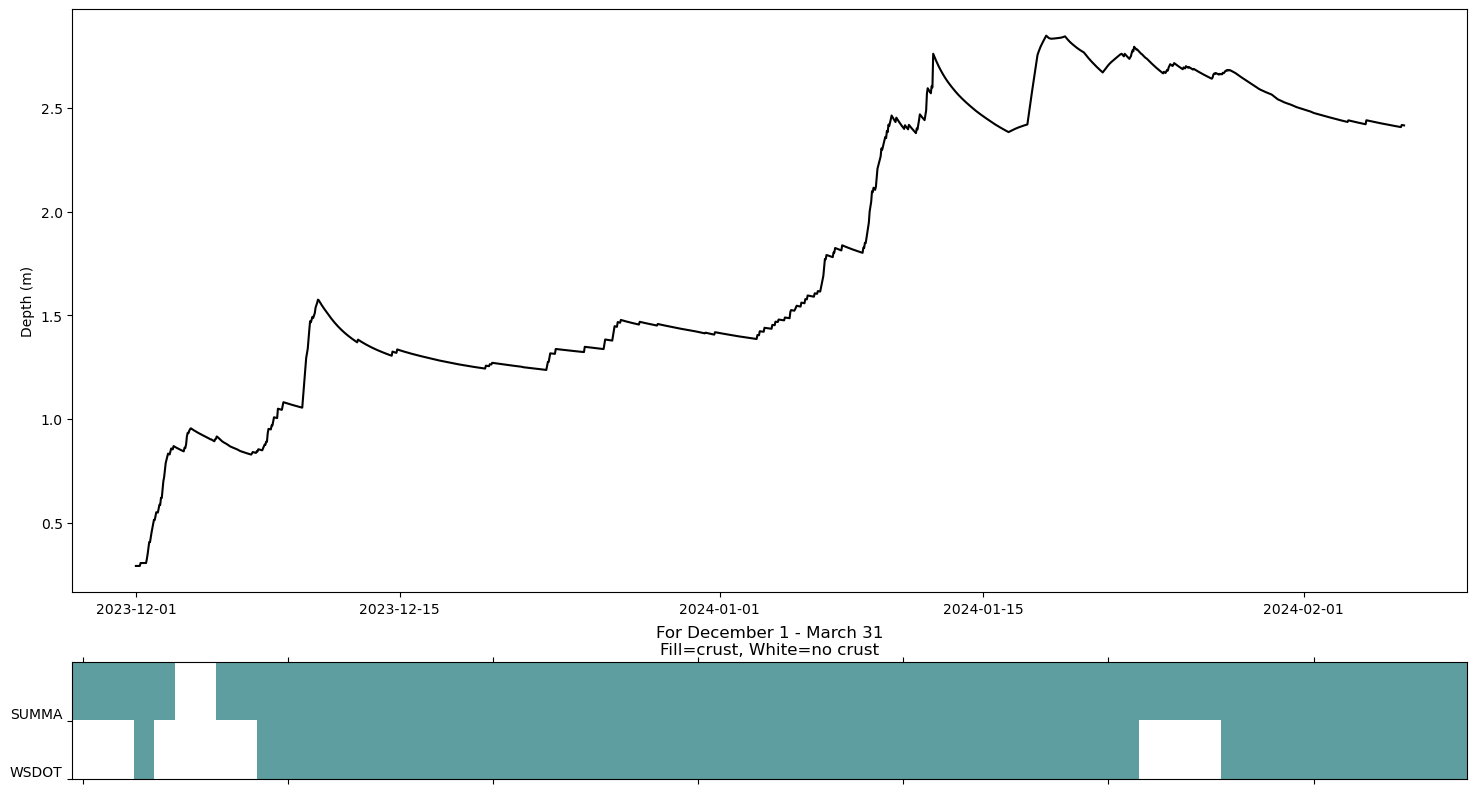

In [ ]:
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(18, 10))

# Create a gridspec with modified height ratios
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 2])

# Create the first subplot
ax0 = plt.subplot(gs[0])

# Assuming layers is a function that plots on the given axes
# layers(var, idepth, plot_soil=False, ax=ax0, add_colorbar=False)
ax0.plot(summa.time, summa.scalarSnowDepth, color='k', label='Snow Depth')
ax0.set_ylabel('Depth (m)')
# ax0.set_title(f'Snow Depth and Density for Ollalie WY24\nF1={f1:.2f}\nBalanced Accuracy={ba_score:.2f}')


# Create a colormap where 1 is mapped to a color and 0 is mapped to white
cmap = plt.cm.colors.ListedColormap(['white', 'cadetblue'])
bounds = [0,0.5,1]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

# Create the second subplot with a modified aspect ratio
ax1 = plt.subplot(gs[1], aspect='auto')

# Plot the DataFrame on the second subplot
cax = ax1.matshow(df_daily_masked_T.values, cmap=cmap, norm=norm, aspect='auto')

# Convert the index to date
dates = df_daily.index.date

# Set the x-axis labels to every 10th date
# ax1.set_xticks(range(0, len(dates), 20))
# ax1.set_xticklabels(dates[::20], rotation=45)  # Rotate labels if they overlap

plt.subplots_adjust(hspace=0.2)  # Increase the value to increase the space between the subplots

ax1.set_xticklabels([])
# Set the y-ticks to the middle of the cells
ax1.set_yticks([0.5, 1.5])

# Set the y-tick labels and shift them up slightly
ax1.set_yticklabels(['SUMMA', 'WSDOT'], verticalalignment='bottom')
ax1.set_title('For December 1 - March 31\nFill=crust, White=no crust')

plt.show()